In [77]:
import random
import math
from alive_progress import alive_bar #progress bar for loops
import matplotlib.pyplot as plt
import numpy as np
import time
import heapq #min-heap priority queue

# PART A

Suppose the input graph G = (V, E) is stored in an adjacency matrix and we
use an array for the priority queue. Implement the Dijkstra’s algorithm using this
setting and analyze its time complexity with respect to |V| and |E| both
theoretically and empirically.

# PART B


Suppose the input graph G = (V, E) is stored in an array of adjacency lists and
we use a minimizing heap for the priority queue. Implement the Dijkstra’s
algorithm using this setting and analyze its time complexity with respect to |V|
and |E| both theoretically and empirically.

### Graph Generation

In [545]:
# Generating random graphs (array of adjacency lists)

# can use for sparse graphs
def generate_random_graph(num_graphs, V, E, max_weight=10): 
    graphs = {V[_]: [] for _ in range(len(V))} if len(V)>1 else {E[_]:[ ] for _ in range(len(E))}
    # print(graphs)
    if len(V)>1:
        keys = V
    else:
        keys = E
    for i in range(len(V)):
        for j in range(num_graphs):
            for k in range(len(E)):
                graph = [[] for _ in range(V[i])]  # adjacency list representation
                edges_added = 0
                while edges_added < E[k]:  # ensure we add exactly E edges
                    u = random.randint(0, V[i]-1)
                    v = random.randint(0, V[i]-1)
                    if u != v and all(nei[0] != v for nei in graph[u]):  # avoid duplicates & self-loop
                        w = random.randint(1, max_weight)
                        graph[u].append((v, w))
                        graph[v].append((u, w)) # undirected
                        edges_added += 1
                if len(V)>1:
                    graphs[keys[i]].append(graph)
                else:
                    graphs[keys[k]].append(graph)
    return graphs

import random

# use for dense graphs, ensures full connectivity
def generate_random_connected_graph(num_graphs, V, E, max_weight=10): 
    graphs = {V[_]: [] for _ in range(len(V))} if len(V) > 1 else {E[_]: [] for _ in range(len(E))}

    if len(V) > 1:
        keys = V
    else:
        keys = E

    for i in range(len(V)):
        for j in range(num_graphs):
            for k in range(len(E)):
                n = V[i]
                target_edges = E[k]*V[i] # total edges = avg edges per vertex * num vertices, average across the whole graph, not a strict per-vertex count
                graph = [[] for _ in range(n)]

                vertices = list(range(n))
                random.shuffle(vertices)
                for idx in range(1, n):
                    u = vertices[idx]
                    v = random.choice(vertices[:idx])
                    w = random.randint(1, max_weight)
                    graph[u].append((v, w))
                    graph[v].append((u, w))
                edges_added = n - 1

                # add extra random edges until we reach target count
                while edges_added < target_edges:
                    u = random.randint(0, n - 1)
                    v = random.randint(0, n - 1)
                    if u != v and all(nei[0] != v for nei in graph[u]):
                        w = random.randint(1, max_weight)
                        graph[u].append((v, w))
                        graph[v].append((u, w))  # undirected
                        edges_added += 1
                if len(V) > 1:
                    graphs[keys[i]].append(graph)
                else:
                    graphs[keys[k]].append(graph)
    return graphs


# fixed num_edges = 5
random.seed(2025) 
num_edges = 20 # average number of edges per vertex
vertex_size = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000, 27500] # number of vertices
graphs_fixed_E = generate_random_connected_graph(5, vertex_size, [num_edges]) # 5 graphs for each vertex size

# fixed num_vertices = 10000
random.seed(2025) 
num_vertices = 10000
edge_size = [2, 3, 4, 5, 6] #average number of edges per vertex
graphs_fixed_V = generate_random_connected_graph(5, [num_vertices], edge_size) 

# Sample graph
g = [
    [(1, 2), (2, 4)],          # neighbors of vertex 0 (neighbor, weight)
    [(0, 2), (2, 1)],          # neighbors of vertex 1
    [(0, 4), (1, 2), (3, 3)],  # neighbors of vertex 2
    [(2, 3)]                   # neighbors of vertex 3
]

In [551]:
def dijkstra_minheap(graph, start):
    V = len(graph)
    S = [False] * V
    d = [math.inf] * V
    pi = [None]* V
    pq = []
    heapq.heappush(pq, (0, start)) # (distance, vertex)

    d[start] = 0
    pi[start] = None
    
    comparisons = 0
    while pq:
        di, u = heapq.heappop(pq)
        if S[u]:
            continue
        else:
            for v, w in graph[u]:
                comparisons += 1
                if d[u] + w < d[v]: #found better path to v, update distance
                    d[v] = d[u] + w
                    pi[v] = u
                    heapq.heappush(pq, (d[v], v))
            S[u] = True
    
    return (d, pi, comparisons)

execution_time_fixedE = {}
execution_comparisons_fixedE = {}

for V, graphs_list in graphs_fixed_E.items():
    total = 0
    total_time = 0
    length = len(graphs_list)
    for j, graph in enumerate(graphs_list):
        # print(f"Running Dijkstra's for V={V}, graph {j+1}/{length}")
        start = time.perf_counter()
        dijkstra_minheap(graph, 0)
        end = time.perf_counter()
        total_time += end - start
        total += dijkstra_minheap(graph, 0)[2]
    execution_time_fixedE[V] = total_time / length
    execution_comparisons_fixedE[V] = total / length

execution_time_fixedV = {}
execution_comparisons_fixedV = {}

for E, graphs_list in graphs_fixed_V.items():
    total = 0
    total_time = 0
    length = len(graphs_list)
    for j, graph in enumerate(graphs_list):
        # print(f"Running Dijkstra's for E={E}, graph {j+1}/{length}")
        start = time.perf_counter()
        dijkstra_minheap(graph, 0)
        end = time.perf_counter()
        total_time += end - start
        total += dijkstra_minheap(graph, 0)[2]
    execution_time_fixedV[E*10000] = total_time / length
    execution_comparisons_fixedV[E*10000] = total / length

print("Comparisons for Varying number of vertices:", execution_time_fixedE)
print("Comparisons for Varying number of edges:", execution_time_fixedV)

Comparisons for Varying number of vertices: {2500: 0.01421993994154036, 5000: 0.03186476002447307, 7500: 0.057657459983602166, 10000: 0.0763090199790895, 12500: 0.10387359992600978, 15000: 0.12260987996123732, 17500: 0.15170334004797043, 20000: 0.18248726003803312, 25000: 0.24313058000989257, 27500: 0.2568341199774295}
Comparisons for Varying number of edges: {20000: 0.011548659997060895, 30000: 0.015772919962182642, 40000: 0.018621919909492135, 50000: 0.021856339927762748, 60000: 0.027053479943424462}


### Theoretical comparisons

In the worst case,

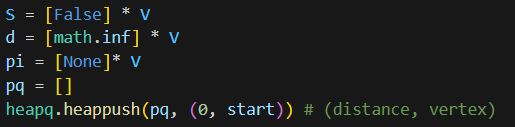<br>
 First 3 = $O(n)$ <br>
 Heap operation = $O(log \ 1)$ = $O(1)$ <br>
 Total = $O(V)$ <br>

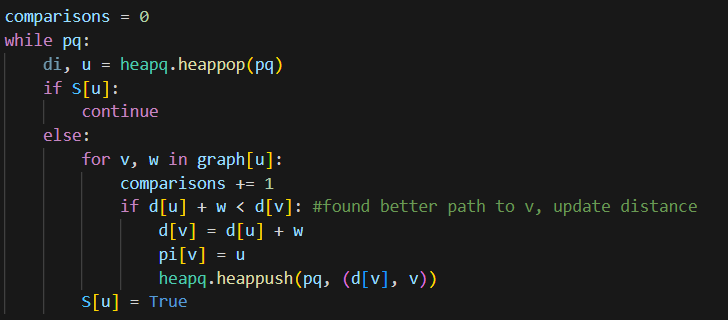<br>
Each edge is pushed into the heap once per inner loop, potentially multiple times <br>
Maximum number of heappush operations: $O(E)$ (one per edge)<br>
Maximum number of heappop operations: $O(V + E)$<br>
Each heap operation = $O(log \ V)$<br>
Heap operations: $O((V + E) \ log \  V)$<br>
Edge comparisons: $O(E)$ <br>
Initialization: $O(V)$<br>
Total: $$O((V + E) \ log \  V)$$

In [552]:
# estimating execution time of one operation
fixedE = list(execution_time_fixedE.values())
fixedE_comparisons = list(execution_comparisons_fixedE.values())
totalfixedE = 0
j = 0
for i in vertex_size:
    totalfixedE += (fixedE[j] / fixedE_comparisons[j])
    j += 1
time_per_op_fixedE = totalfixedE / len(vertex_size)

print("Estimated time per operation (fixed E):", time_per_op_fixedE)

fixedV = list(execution_time_fixedV.values())
fixedV_comparisons = list(execution_comparisons_fixedV.values())
totalfixedV = 0
j = 0
for i in edge_size:
    # print(i)
    totalfixedV += (fixedV[j] / fixedV_comparisons[j])
    j += 1
time_per_op_fixedV = totalfixedV / len(edge_size)

print("Estimated time per operation (fixed V):", time_per_op_fixedV)

def theoretical_comparisons(V, E):
    return (E + V) * math.log2(V)

theoretical_comparisons_fixedV = {S*10000: theoretical_comparisons(10000, S*10000) for S in edge_size}
theoretical_comparisons_fixedE = {S: theoretical_comparisons(S, 20*S) for S in vertex_size}   
theoretical_time_fixedV = {S*10000: theoretical_comparisons(10000, S*10000) * time_per_op_fixedV for S in edge_size}
theoretical_time_fixedE = {S: theoretical_comparisons(S, 20*S) * time_per_op_fixedV for S in vertex_size}   

Estimated time per operation (fixed E): 2.018028558436247e-07
Estimated time per operation (fixed V): 2.4567631272754326e-07


### Plotting time taken against number of vertices, V (log scale)

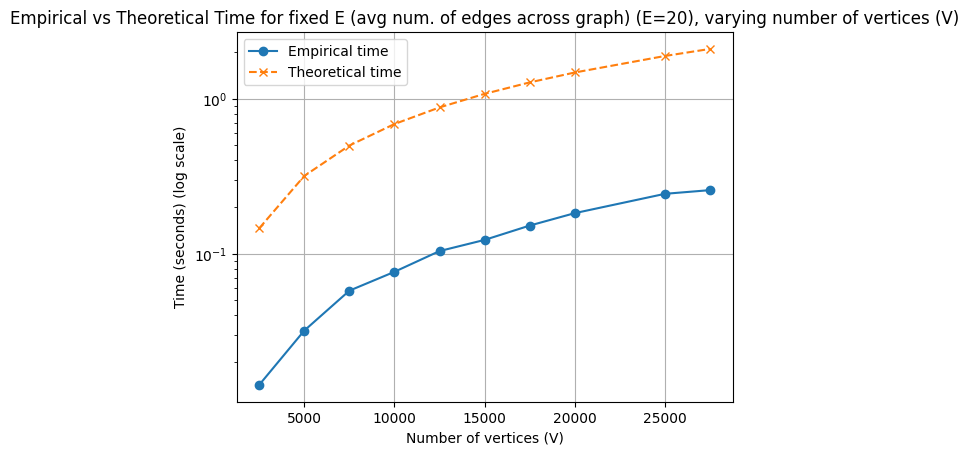

In [571]:
# plotting empirical vs theoretical results
plt.plot(list(execution_time_fixedE.keys()), list(execution_time_fixedE.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_time_fixedE.keys()), list(theoretical_time_fixedE.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of vertices (V)")
plt.ylabel("Time (seconds) (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Time for fixed E (avg num. of edges across graph) (E={num_edges}), varying number of vertices (V)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting number of comparisons against number of vertices, V (log scale)

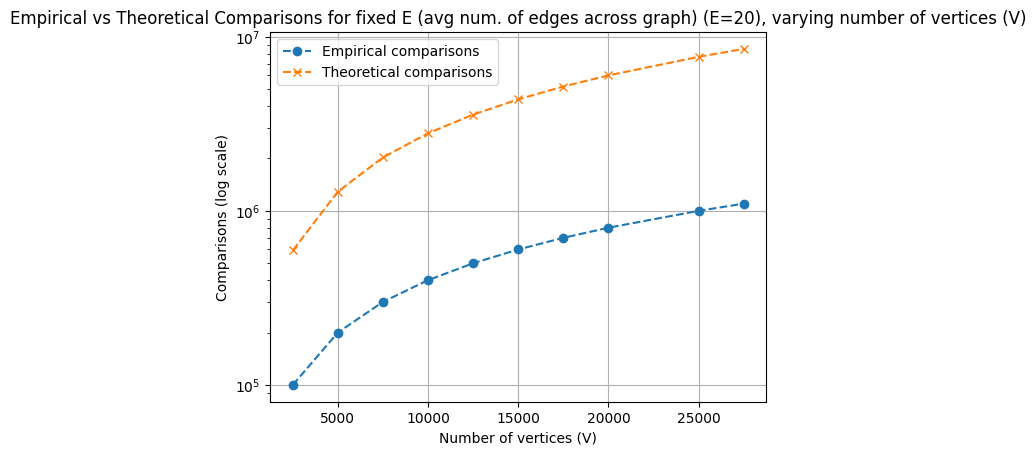

In [572]:
plt.plot(list(execution_comparisons_fixedE.keys()), list(execution_comparisons_fixedE.values()), label="Empirical comparisons", linestyle="--", marker="o")
plt.plot(list(theoretical_comparisons_fixedE.keys()), list(theoretical_comparisons_fixedE.values()), label="Theoretical comparisons", linestyle="--", marker="x")
plt.xlabel("Number of vertices (V)")
plt.ylabel("Comparisons (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Comparisons for fixed E (avg num. of edges across graph) (E={num_edges}), varying number of vertices (V)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting time taken against number of edges, E*10000 (log scale)

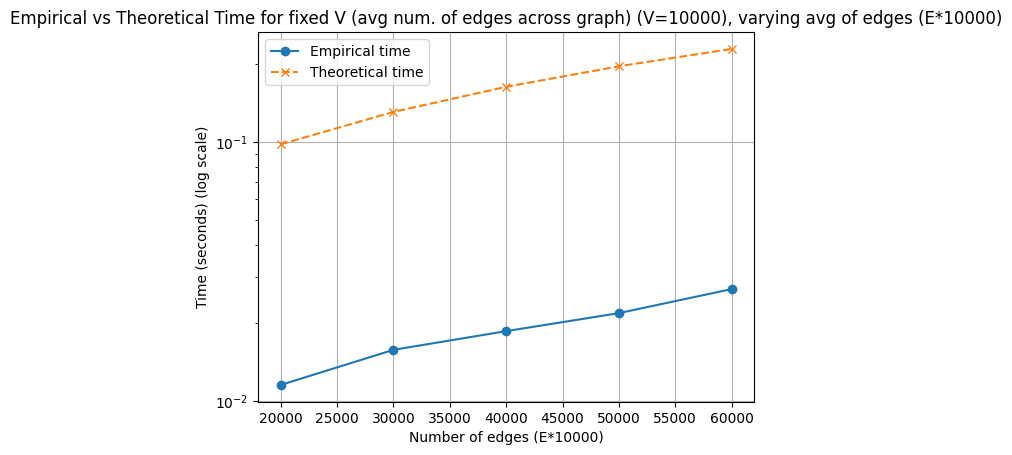

In [579]:
# plotting empirical vs theoretical results
plt.plot(list(execution_time_fixedV.keys()), list(execution_time_fixedV.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_time_fixedV.keys()), list(theoretical_time_fixedV.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of edges (E*10000)")
plt.ylabel("Time (seconds) (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Time for fixed V (avg num. of edges across graph) (V={num_vertices}), varying avg of edges (E*10000)")
plt.legend()
plt.grid(True)
plt.show()

### Plotting number of comparisons against number of edges, E*10000 (log scale)

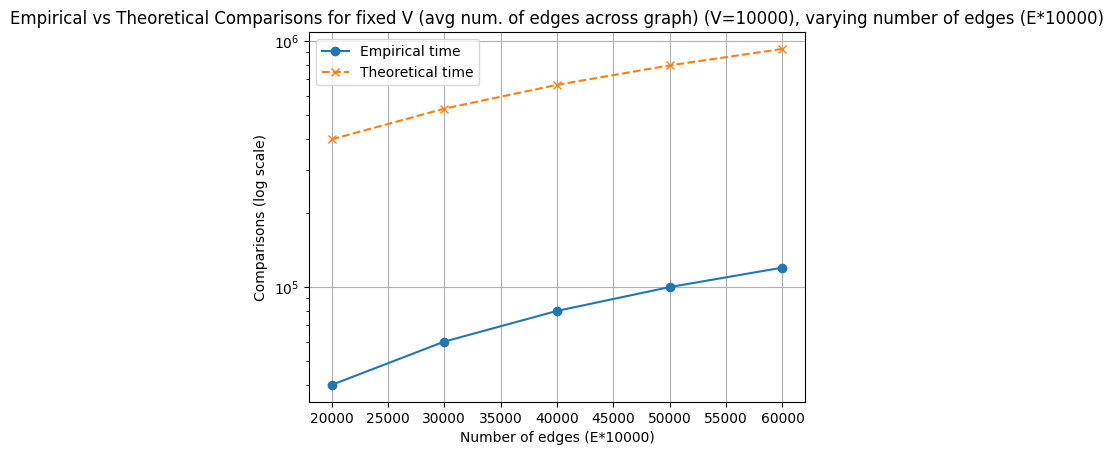

In [581]:
# plotting empirical vs theoretical results
plt.plot(list(execution_comparisons_fixedV.keys()), list(execution_comparisons_fixedV.values()), label="Empirical time", marker="o")
plt.plot(list(theoretical_comparisons_fixedV.keys()), list(theoretical_comparisons_fixedV.values()), label="Theoretical time", linestyle="--", marker="x")

plt.xlabel("Number of edges (E*10000)")
plt.ylabel("Comparisons (log scale)")
plt.yscale("log")
plt.title(f"Empirical vs Theoretical Comparisons for fixed V (avg num. of edges across graph) (V={num_vertices}), varying number of edges (E*10000)")
plt.legend()
plt.grid(True)
plt.show()

### Reasons for discrepancy
Theoretical bound assumes the worst-case graph layout and maximum heap usage per edge and vertex.

In random, fully connected graphs (with high but not maximum edge counts per node), Dijkstra's algorithm empirically performs fewer relaxations, many alternative paths are quickly deemed non-optimal, and their associated heap and comparison costs are avoided.

# Part C

maybe compare sparse and dense graphs